In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [3]:
from keras import backend as K
from keras import utils


In [4]:
X_test = np.load("/content/drive/MyDrive/project_data/X_test.npy")
y_test = np.load("/content/drive/MyDrive/project_data/y_test.npy")
person_train_valid = np.load("/content/drive/MyDrive/project_data/person_train_valid.npy")
X_train_valid = np.load("/content/drive/MyDrive/project_data/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/project_data/y_train_valid.npy")
person_test = np.load("/content/drive/MyDrive/project_data/person_test.npy")

In [5]:
N_trials,N_eeg,N_bins  = X_train_valid.shape
X_train_valid = np.reshape(X_train_valid,(N_trials,N_eeg,N_bins,1))
N_trials,N_eeg,N_bins_ = X_test.shape
X_test = np.reshape(X_test,(N_trials,N_eeg,N_bins,1))


print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))


Training/Valid data shape: (2115, 22, 1000, 1)
Test data shape: (443, 22, 1000, 1)
Training/Valid target shape: (2115,)
Test target shape: (443,)


In [6]:
def map_classes(y) :

  for i in range(len(y)):

    if y[i] == 769:
      y[i] = 0
    elif y[i] == 770:
      y[i] = 1
    elif y[i] == 771:
      y[i] = 2
    elif y[i] == 772:
      y[i] = 3
    else:
      return None

  return y

In [7]:
y_train_valid = map_classes(y_train_valid)
y_test = map_classes(y_test)

In [8]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
def NetworkParameters (image_size,batch_size,kernel_size, filters, latent_dim, epochs):

  input_shape = (image_size[0], image_size[1],1)
  image_size = input_shape
  batch_size = batch_size
  kernel_size = kernel_size
  filters = filters
  latent_dim = latent_dim
  epochs = epochs
  return input_shape,image_size,batch_size,kernel_size, filters, latent_dim, epochs

(input_shape, 
 image_size,
 batch_size, 
 kernel_size, 
 filters, 
 latent_dim, 
 epochs) = NetworkParameters(image_size = X_train_valid.shape[1:3],
                                                    batch_size = 128,
                                                    kernel_size = 7,
                                                    filters = 16,
                                                    latent_dim = 2,
                                                    epochs = 50)

In [10]:
latent_dim = 2
encoder_inputs = keras.Input(input_shape)
x = layers.Conv2D(filters=32, kernel_size = (1,50), strides = (1,25), activation="relu")(encoder_inputs)
x = layers.Conv2D(filters=64, kernel_size =(22,1), activation="relu")(x)
shape = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 22, 1000, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 22, 39, 32)   1632        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 1, 39, 64)    45120       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 2496)         0           ['conv2d_1[0][0]']         

In [11]:
encoder_inputs

<KerasTensor: shape=(None, 22, 1000, 1) dtype=float32 (created by layer 'input_1')>

In [12]:
shape

(None, 1, 39, 64)

In [13]:
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = layers.Reshape((shape[1], shape[2], shape[3]))(x)

x = layers.Conv2DTranspose(filters = 64, kernel_size = (22,1), activation="relu")(x)
x = layers.Conv2DTranspose(filters = 32, kernel_size = (1,50), activation="relu", strides=(1,25))(x)
decoder_outputs = layers.Conv2DTranspose(filters = 1, kernel_size=(1,50), padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 2496)              7488      
                                                                 
 reshape (Reshape)           (None, 1, 39, 64)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 22, 39, 64)       90176     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 22, 1000, 32)     102432    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 22, 1000, 1)      1601

In [14]:
outputs = decoder(encoder(encoder_inputs)[2])
vae = keras.Model(encoder_inputs, outputs, name='vae')

In [15]:
import argparse
from keras.losses import mse, binary_crossentropy


In [16]:
import matplotlib.pyplot as plt
import argparse
import os

def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_eeg"):
    
    encoder, decoder = models
    x_test, y_test = data
    print(x_test.shape)
    print(y_test.shape)
    os.makedirs(model_name, exist_ok=True)

    # display a 2D plot of the classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

  

    z_sample = np.array([[22,1000]])
    x_decoded = decoder.predict(z_sample)
    print(x_decoded.shape)
    fs = 250
    increments = np.linspace(0,1000,1000)
    
    plt.figure()

    for i in range(0, 22):
      y = np.row_stack((x_decoded[:,i,:,:]))

      plt.plot(increments, (y), '.')
      plt.xlabel("Sample Index [n]")
      plt.ylabel("z[n]")
      plt.title("Single Trial, all EEG")



Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 22, 1000, 1  0           []                               
                                )]                                                                
                                                                                                  
 encoder (Functional)           [(None, 2),          86772       ['input_1[0][0]']                
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 22, 1000, 1)  201697      ['encoder[0][2]']              

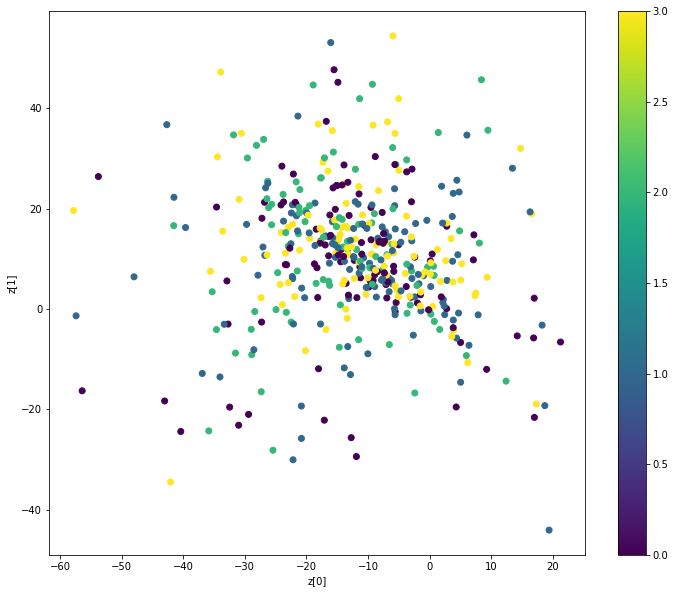

(1, 22, 1000, 1)


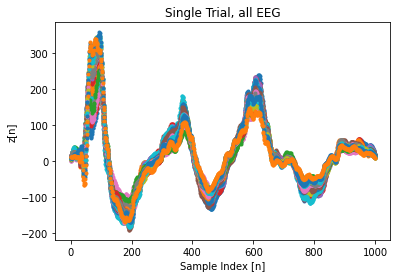

In [17]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    help_ = "Load h5 model trained weights"
    parser.add_argument("-w", "--weights", help=help_)
    help_ = "Use mse loss instead of binary cross entropy (default)"
    parser.add_argument("-m", "--mse", help=help_, action='store_true')
    args = parser.parse_args(args = [])
    models = (encoder, decoder)
    data = (X_test, y_test)


    if args.mse:
        reconstruction_loss = mse(K.flatten(encoder_inputs), K.flatten(outputs))
    else:
        reconstruction_loss = mse(K.flatten(encoder_inputs), K.flatten(outputs))
  

    reconstruction_loss *= image_size[0] * image_size[1]
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.1, beta_2=0.999, amsgrad=False)

    vae.compile(optimizer=optimizer, loss=None, metrics = ['categorical_accuracy'])

    vae.summary()

    if args.weights:
        vae.load_weights(args.weights)
    else:
        history = vae.fit(x = X_train_valid,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_test, None))
    #plot
    plot_results(models, data, batch_size=batch_size, model_name="vae_cnn")

In [18]:

test_loss, test_acc = vae.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

14/14 [==============================] - 1s 37ms/step - loss: 2435773.5000 - categorical_accuracy: 0.1445
Test accuracy 0.14446952939033508
Test loss 2435773.5


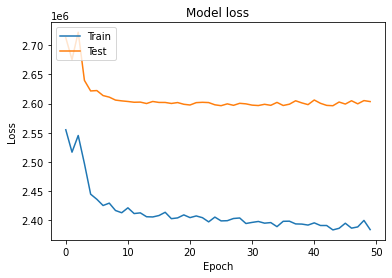

In [19]:
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("Model_Loss.png")